# Clean Metadata
This notebook processes raw metadata provided by GISAID into the format required by Augur. Furthermore, it extracts additional information into unique variables.

## Setup

### Imports

In [1]:
import glob
import numpy as np
import pandas as pd
import plotnine as p9
import re

# Custom cleaning functions
from data.prep_data.clean_seqs import clean_strain_names
from data.prep_data.clean_seqs import deduplicate

### Files

#### Inputs

In [2]:
region = "background"

In [3]:
input_gisaid_files = glob.glob(f'h3n2/data/raw/background/*.xls')

#### Outputs



In [4]:
export_augur = f'h3n2/data/clean/{region}_clean.tsv'

### Parameters

## Load raw data from GISAID

In [5]:
# Read each file into a dataframe
dfs = [pd.read_excel(file) for file in input_gisaid_files]

# Join all dataframes into one
meta_raw = pd.concat(dfs, ignore_index=True)
meta_raw.head()

,Isolate_Id,PB2 Segment_Id,PB1 Segment_Id,PA Segment_Id,HA Segment_Id,NP Segment_Id,NA Segment_Id,MP Segment_Id,NS Segment_Id,HE Segment_Id,...,PB2 INSDC_Upload,PB1 INSDC_Upload,PA INSDC_Upload,HA INSDC_Upload,NP INSDC_Upload,NA INSDC_Upload,MP INSDC_Upload,NS INSDC_Upload,HE INSDC_Upload,P3 INSDC_Upload
0,EPI_ISL_15427761,EPI2195545|A/Saint-Petersburg/1/2022,EPI2195546|A/Saint-Petersburg/1/2022,EPI2195547|A/Saint-Petersburg/1/2022,EPI2195548|A/Saint-Petersburg/1/2022,EPI2195549|A/Saint-Petersburg/1/2022,EPI2195550|A/Saint-Petersburg/1/2022,EPI2195551|A/Saint-Petersburg/1/2022,EPI2195552|A/Saint-Petersburg/1/2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPI_ISL_15509564,NaN,NaN,NaN,EPI2197095|A/Conwy/2738/2022,EPI2197098|A/Conwy/2738/2022,EPI2197097|A/Conwy/2738/2022,EPI2197096|A/Conwy/2738/2022,EPI2197099|A/Conwy/2738/2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EPI_ISL_15509589,EPI2197107|A/Bedlinog/4743/2022,EPI2197106|A/Bedlinog/4743/2022,EPI2197105|A/Bedlinog/4743/2022,EPI2197100|A/Bedlinog/4743/2022,EPI2197103|A/Bedlinog/4743/2022,EPI2197102|A/Bedlinog/4743/2022,EPI2197101|A/Bedlinog/4743/2022,EPI2197104|A/Bedlinog/4743/2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EPI_ISL_15509686,NaN,NaN,NaN,EPI2197108|A/Cardiff/5987/2022,EPI2197111|A/Cardiff/5987/2022,EPI2197110|A/Cardiff/5987/2022,EPI2197109|A/Cardiff/5987/2022,EPI2197112|A/Cardiff/5987/2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EPI_ISL_15509732,NaN,NaN,NaN,EPI2197113|A/CefnCoed/7057/2022,EPI2197116|A/CefnCoed/7057/2022,EPI2197115|A/CefnCoed/7057/2022,EPI2197114|A/CefnCoed/7057/2022,EPI2197117|A/CefnCoed/7057/2022,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Restrict to H3N2 samples.
print(meta_raw['Subtype'].unique())
meta_raw = meta_raw.query('Subtype == "A / H3N2"')
print(meta_raw['Subtype'].unique())

['A / H3N2' 'A / H9N2' 'A / H6N2' 'A / H1N1' 'A / H5N1' 'A / H3'
 'A / H1N2' 'A / H1' 'A / H3N8' 'A / H4N6' 'A / H3N3' 'A / H6N1'
 'A / H2N8' 'A / H5N5' 'A / H4N1' 'A / H5' 'A / H2N5' 'A / H5N9'
 'A / H5N3' 'A / H2N1' 'A / H11N9' 'A / H3N6' 'A / H5N2' 'A / H2N3'
 'A / H9N9' 'A / H9' 'A / H7N7' 'A / H12N7' 'A / H12N5' 'A / H5N8']
['A / H3N2']


Keep only the columns we are interested in.

In [7]:
retained_cols = [
    'Isolate_Name',
    'Collection_Date',
    'Isolate_Id',
    'Location',
    'Host',
    'Submitting_Lab',
    'Originating_Lab']

meta_working = meta_raw[retained_cols]

Standardize column name formatting:
- all lowercase
- underscore for word separation (already true)

In [8]:
meta_working.columns = [c.lower() for c in meta_working.columns]

Provide [required columns](https://docs.nextstrain.org/projects/ncov/en/wdl-optionals/analysis/data-prep.html#required-metadata) for Nextstrain.

In [9]:
meta_working = meta_working.rename(
    columns = {
        'isolate_name': 'strain',
        'collection_date': 'date'
    }
)
meta_working['virus'] = 'h3n2_flu'

In [10]:
meta_working.head(n=20)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus
0,A/Saint-Petersburg/12-1V/2022,2022-10-10,EPI_ISL_15427761,Europe / Russian Federation / Saint Petersburg,Human,State Research Center of Virology and Biotechn...,"FBUZ ""Center of hyhiene and epidemiology""",h3n2_flu
1,A/Conwy/2738/2022,2022-10-06,EPI_ISL_15509564,Europe / United Kingdom / County Borough of Conwy,Human,Public Health Wales Microbiology Cardiff,Public Health Wales Microbiology Cardiff,h3n2_flu
2,A/Bedlinog/4743/2022,2022-10-04,EPI_ISL_15509589,Europe / United Kingdom / County Borough of Rh...,Human,Public Health Wales Microbiology Cardiff,Public Health Wales Microbiology Cardiff,h3n2_flu
3,A/Cardiff/5987/2022,2022-10-05,EPI_ISL_15509686,Europe / United Kingdom / City and County of C...,Human,Public Health Wales Microbiology Cardiff,Public Health Wales Microbiology Cardiff,h3n2_flu
4,A/CefnCoed/7057/2022,2022-10-06,EPI_ISL_15509732,Europe / United Kingdom / County Borough of Me...,Human,Public Health Wales Microbiology Cardiff,Public Health Wales Microbiology Cardiff,h3n2_flu
5,A/ Austria/1557604/2022,2022-10-11,EPI_ISL_15517642,Europe / Austria / Bundesland Tirol,Human,Medical University Vienna,"Department of Virology, Medical University Vienna",h3n2_flu
6,A/Austria/1557988/2022,2022-10-12,EPI_ISL_15517657,Europe / Austria / Bundesland Steiermark,Human,Medical University Vienna,"Department of Virology, Medical University Vienna",h3n2_flu
7,A/Austria/1559914/2022,2022-10-18,EPI_ISL_15517658,Europe / Austria / Vorarlberg,Human,Medical University Vienna,"Department of Virology, Medical University Vienna",h3n2_flu
8,A/Austria/1559932/2022,2022-10-19,EPI_ISL_15517785,Europe / Austria / Bundesland Oberosterreich,Human,Medical University Vienna,"Department of Virology, Medical University Vienna",h3n2_flu
9,A/Austria/1555330/2022,2022-10-02,EPI_ISL_15517786,Europe / Austria / Bundesland Tirol,Human,Medical University Vienna,"Department of Virology, Medical University Vienna",h3n2_flu


## Parse metadata

### Parse country

In [11]:
split_columns = meta_working['location'].str.split(' / ', expand=True)
meta_working['region'] = split_columns[0]
meta_working['country'] = split_columns[1]

In [12]:
meta_working.head(n=10)

,strain,date,isolate_id,location,host,submitting_lab,originating_lab,virus,region,country
0,A/Saint-Petersburg/12-1V/2022,2022-10-10,EPI_ISL_15427761,Europe / Russian Federation / Saint Petersburg,Human,State Research Center of Virology and Biotechn...,"FBUZ ""Center of hyhiene and epidemiology""",h3n2_flu,Europe,Russian Federation
1,A/Conwy/2738/2022,2022-10-06,EPI_ISL_15509564,Europe / United Kingdom / County Borough of Conwy,Human,Public Health Wales Microbiology Cardiff,Public Health Wales Microbiology Cardiff,h3n2_flu,Europe,United Kingdom
2,A/Bedlinog/4743/2022,2022-10-04,EPI_ISL_15509589,Europe / United Kingdom / County Borough of Rh...,Human,Public Health Wales Microbiology Cardiff,Public Health Wales Microbiology Cardiff,h3n2_flu,Europe,United Kingdom
3,A/Cardiff/5987/2022,2022-10-05,EPI_ISL_15509686,Europe / United Kingdom / City and County of C...,Human,Public Health Wales Microbiology Cardiff,Public Health Wales Microbiology Cardiff,h3n2_flu,Europe,United Kingdom
4,A/CefnCoed/7057/2022,2022-10-06,EPI_ISL_15509732,Europe / United Kingdom / County Borough of Me...,Human,Public Health Wales Microbiology Cardiff,Public Health Wales Microbiology Cardiff,h3n2_flu,Europe,United Kingdom
5,A/ Austria/1557604/2022,2022-10-11,EPI_ISL_15517642,Europe / Austria / Bundesland Tirol,Human,Medical University Vienna,"Department of Virology, Medical University Vienna",h3n2_flu,Europe,Austria
6,A/Austria/1557988/2022,2022-10-12,EPI_ISL_15517657,Europe / Austria / Bundesland Steiermark,Human,Medical University Vienna,"Department of Virology, Medical University Vienna",h3n2_flu,Europe,Austria
7,A/Austria/1559914/2022,2022-10-18,EPI_ISL_15517658,Europe / Austria / Vorarlberg,Human,Medical University Vienna,"Department of Virology, Medical University Vienna",h3n2_flu,Europe,Austria
8,A/Austria/1559932/2022,2022-10-19,EPI_ISL_15517785,Europe / Austria / Bundesland Oberosterreich,Human,Medical University Vienna,"Department of Virology, Medical University Vienna",h3n2_flu,Europe,Austria
9,A/Austria/1555330/2022,2022-10-02,EPI_ISL_15517786,Europe / Austria / Bundesland Tirol,Human,Medical University Vienna,"Department of Virology, Medical University Vienna",h3n2_flu,Europe,Austria


## Clean dataframe
Clean up values.

Clean strain names
* strip leading and trailing whitespace
* replace spaces with underscores
* replace apostrophes with dashes

In [13]:
meta_working['strain'] = (
    meta_working['strain']
    .apply(lambda x: clean_strain_names(x))
)

In [14]:
meta_working.head(n=10)['strain']

0    A/Saint-Petersburg/12-1V/2022
1                A/Conwy/2738/2022
2             A/Bedlinog/4743/2022
3              A/Cardiff/5987/2022
4             A/CefnCoed/7057/2022
5          A/_Austria/1557604/2022
6           A/Austria/1557988/2022
7           A/Austria/1559914/2022
8           A/Austria/1559932/2022
9           A/Austria/1555330/2022
Name: strain, dtype: object

### Deduplicate strains

In [15]:
meta_working = deduplicate(meta_working, 'strain')

Originally, there were 80648 records.
	There were 68689 unique records.
	After cleaning, there were 68689 records remaining.


### Clean up countries

In [16]:
meta_working['country'].value_counts(dropna=False)

country
United States                           16538
United Kingdom                           5396
Spain                                    4410
Russian Federation                       3272
Canada                                   3203
                                        ...  
Aruba                                       1
Saint Kitts and Nevis, Federation of        1
Iraq                                        1
Tajikistan                                  1
Saint Vincent and the Grenadines            1
Name: count, Length: 153, dtype: int64

In [17]:
meta_working['country'] = (
    meta_working['country']
    .replace(
        {'Saint Kitts and Nevis, Federation of': 'Saint Kitts and Nevis',
         'Congo, the Democatic Republic of': 'DRC',
         'Tanzania, United Republic of': 'Tanzania',
         "Lao, People's Democratic Republic": 'Laos',
         'Korea, Republic of': 'South Korea',
         'Hong Kong (SAR)': 'Hong Kong',
         'Iran, Islamic Republic of': 'Iran',
         'Palestinian Territory': 'Palestine',
         "Macedonia, the former Yogoslav Republic of": 'Macedonia',
         'Moldova, Republic of  ': 'Moldova',
         'Saint Kitts and Nevis, Federation of': 'Saint Kitts and Nevis'}
    ))

In [18]:
meta_working['country'].value_counts(dropna=False)

country
United States                       16538
United Kingdom                       5396
Spain                                4410
Russian Federation                   3272
Canada                               3203
                                    ...  
Aruba                                   1
Saint Kitts and Nevis                   1
Iraq                                    1
Tajikistan                              1
Saint Vincent and the Grenadines        1
Name: count, Length: 153, dtype: int64

## Export for Augur
Export tab-delimited file (TSV) for input into Augur.

- Replace `NaN` values with a question mark character (`?`), as preferred by Augur.
- Drop raw columns that have been parsed to new, expanded columns.
- Put columns in preferred order. This is not necessary for Augur, but provides a standard order for my own human reading.
- **Drop duplicate strains.**

In [19]:
col_order = [
    'strain',
    'date',
    'virus',
    'region', 
    'country',
    'host', 
    'isolate_id',
    'submitting_lab',
    'originating_lab']

meta_working = meta_working[col_order]

meta_clean = meta_working.fillna('?')

meta_clean.to_csv(export_augur, sep='\t', index=False, header=False)

## Plot and list all strains by country

### Plot strain counts by country

In [20]:
meta_clean['strain'].count()

68689

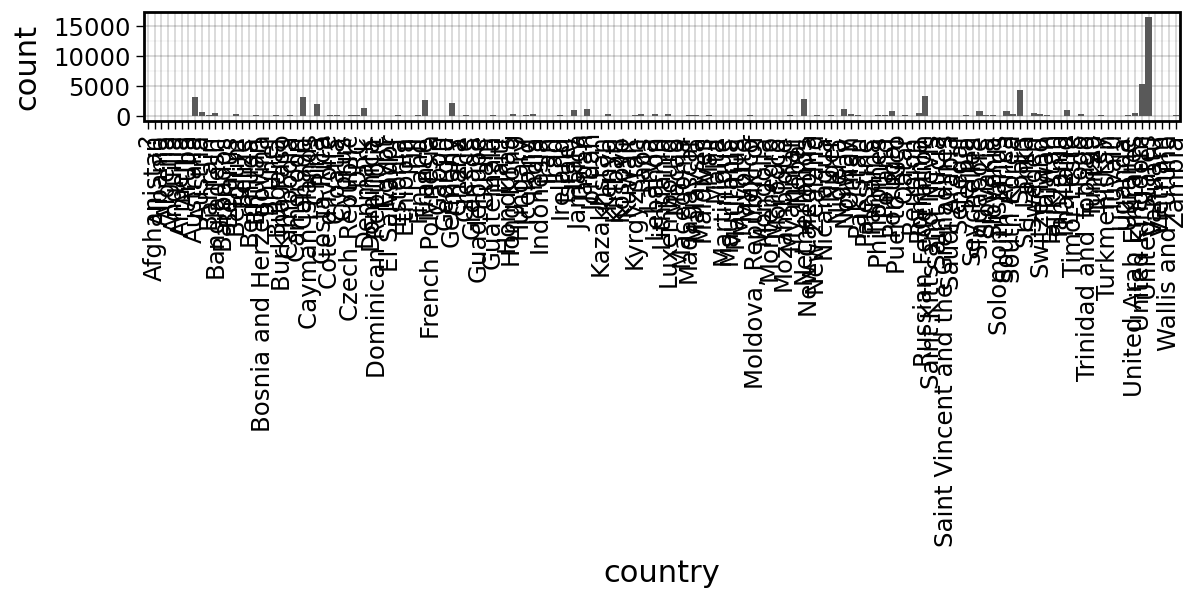

In [21]:
seqs_by_country = (
    p9.ggplot(meta_clean, p9.aes(x='country'))
    + p9.geom_bar()
    + p9.theme_linedraw()
    + p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5))  # Adjust hjust value here
    + p9.theme(figure_size=(6, 3))
)

seqs_by_country


### List strains by country

In [22]:
by_country = meta_working.groupby('country')['strain'].unique()
for key, value in by_country.items():
    print(f"{key} (n={len(value)})")
    for v in value:
        print(v)

Afghanistan (n=56)
A/Afghanistan/6412/2023
A/Afghanistan/5931/2023
A/Afghanistan/6262/2023
A/Afghanistan/6250/2023
A/Afghanistan/5930/2023
A/Afghanistan/5803/2023
A/Afghanistan/5687/2023
A/Afghanistan/5614/2023
A/Afghanistan/5800/2023
A/Afghanistan/5791/2023
A/Afghanistan/6257/2023
A/Afghanistan/6411/2023
A/Afghanistan/5792/2023
A/Afghanistan/5929/2023
A/Afghanistan/5679/2023
A/Afghanistan/5373/2021
A/Afghanistan/4839/2021
A/Afghanistan/5317/2021
A/Afghanistan/5022/2021
A/Afghanistan/4966/2021
A/Afghanistan/4900/2021
A/Afghanistan/4862/2021
A/Afghanistan/4961/2021
A/Afghanistan/4980/2021
A/Afghanistan/5311/2021
A/Afghanistan/4982/2021
A/Afghanistan/4819/2021
A/Afghanistan/4837/2021
A/Afghanistan/4979/2021
A/Afghanistan/4851/2021
A/Afghanistan/6100/2021
A/Afghanistan/4820/2021
A/Afghanistan/4834/2021
A/Afghanistan/5113/2021
A/Afghanistan/4903/2021
A/Afghanistan/5142/2021
A/Afghanistan/5202/2021
A/Afghanistan/5206/2021
A/Afghanistan/4960/2021
A/Afghanistan/4955/2021
A/Afghanistan/4988/20